# ECE 689, Spring 2025
## Homework 2

## Full name: 

Please submit the homework as pdf file.

## Imports and Datasets

In [1]:
# Import some useful packages, please edit as needed

import numpy as np 
import matplotlib.pyplot as plt  
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import copy

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# # Import some datasets, please plot to make sure it works


# # load swiss roll

# # Load IHDP
# from causalforge.data_loader import DataLoader

# r = DataLoader.get_loader('IHDP').load()
# X_tr, T_tr, YF_tr, YCF_tr, mu_0_tr, mu_1_tr, X_te, T_te, YF_te, YCF_te, mu_0_te, mu_1_te = r



## Question 1: Score-Based Generative Model with Sliced Score Matching on MNIST

(A helpful website: https://github.com/mfkasim1/score-based-tutorial/blob/main/01-SGM-without-SDE.ipynb)

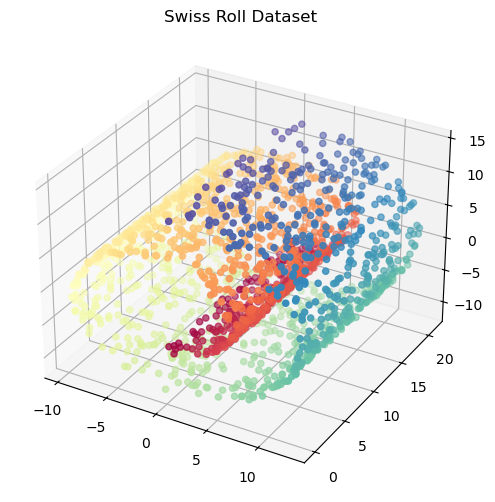

In [4]:
""" Data Preparation """
# import the necessary library to load the swiss roll dataset
from torchvision import transforms

# load swiss roll
from sklearn.datasets import make_swiss_roll

# Generate Swiss Roll dataset
n_samples = 2000
noise = 0.1
X, t = make_swiss_roll(n_samples=n_samples, noise=noise)

# Split into train and test datasets (convert numpy arrays to torch tensors)
train_size = int(0.8 * n_samples)
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X[:train_size]).float(), 
)
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X[train_size:]).float()
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Plot the dataset
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.Spectral)
ax.set_title("Swiss Roll Dataset")
plt.show()


In [5]:
""" Model Architecture """
# score_network takes input of Swiss Roll image dimension and returns the output of
# the same size, socre network usually follows the structure of U-Net

# Residual Block with Softplus Activation
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            nn.SiLU(),
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            nn.SiLU()
        )
        
    def forward(self, x):
        return x + self.net(x)

class ScoreNetwork(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, num_res_blocks=4):
        super().__init__()
        
        # Initial projection
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU()
        )
        
        # Residual blocks
        self.res_blocks = nn.ModuleList([
            ResidualBlock(hidden_dim) for _ in range(num_res_blocks)
        ])
        
        # Final projection to get the score
        self.final = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, input_dim)
        )
        
    def forward(self, x):
        # x shape: (batch_size, 3)
        h = self.input_proj(x)
        
        # Apply residual blocks
        for block in self.res_blocks:
            h = block(h)
        
        # Project to score
        score = self.final(h)
        
        return score

In [6]:
"""Sliced Score Matching"""
# Implement the sliced score matching function, as illustrated in sldes 26-28
# of lectur 4 of Teaching Staff Lecture Slides
# Sliced Score Matching Loss (Adapted from [1][5][8])
def sliced_score_matching_loss(model, x, n_particles=1):
    """
    The loss is defined as:

    $$ 
    \mathcal{L}_{\mathrm{SSM}}(\theta) = \mathbb{E}_{p(x),\,v}\left[
    \frac{1}{2}\; v^\top \nabla_x s_\theta(x)\, v + \frac{1}{2}\; \left(v^\top s_\theta(x)\right)^2 
    \right],
    $$

    where $s_\theta(x)$ is the model’s score and $v$ is a random unit vector.
    """
    # Ensure input x requires gradient.
    x.requires_grad_(True)
    B, d = x.shape  # batch size and dimensions

    # Generate n_particles random projection directions per sample.
    # Shape: (B, n_particles, d)
    v = torch.randn(B, n_particles, d, device=x.device, dtype=x.dtype)
    v = v / (v.norm(dim=-1, keepdim=True) + 1e-10)

    # Compute the score function: s(x) = model(x), shape (B, d)
    score = model(x)

    # Expand score for the particles: (B, n_particles, d)
    score_expanded = score.unsqueeze(1).expand(-1, n_particles, -1)

    # Compute the projected score: 
    # $$ s_v(x) = v^\top s_\theta(x) $$
    # Shape: (B, n_particles)
    score_v = (score_expanded * v).sum(dim=-1)

    # To compute the directional derivative, we need to compute
    # $$ v^\top \nabla_x s_\theta(x) \, v = \nabla_x (v^\top s_\theta(x)) \cdot v. $$
    # We compute this by processing each particle separately.

    # Reshape v and corresponding x for vectorized computation.
    # v: (B*n_particles, d)
    v_flat = v.reshape(B * n_particles, d)
    # Replicate x for each particle: (B*n_particles, d)
    x_repeated = x.unsqueeze(1).expand(-1, n_particles, -1).reshape(B * n_particles, d)

    # Compute the score for repeated x: shape (B*n_particles, d)
    score_rep = model(x_repeated)
    # Compute inner product: (B*n_particles,)
    inner = (score_rep * v_flat).sum(dim=1)

    # Compute gradient of the summed inner product wrt. x_repeated.
    grad_inner = torch.autograd.grad(inner.sum(), x_repeated, create_graph=True)[0]
    # Compute the directional derivative: v^\top grad_inner, shape (B*n_particles,)
    grad_v = (grad_inner * v_flat).sum(dim=1)
    # Reshape it back to shape: (B, n_particles)
    grad_v = grad_v.reshape(B, n_particles)

    # Assemble the final loss for each sample and each particle:
    # $$ \ell = \frac{1}{2}\; \text{grad\_v} + \frac{1}{2}\; \left( s_v(x) \right)^2 $$
    loss = 0.5 * grad_v + 0.5 * score_v ** 2

    # Average over particles and batch.
    loss = loss.mean()

    x.requires_grad_(False)
    return loss


<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3662151/3653208562.py:6: SyntaxWarning: invalid escape sequence '\m'
  """


In [8]:
"""Training"""
# Training function
def train_score_model(model, train_loader, optimizer, n_epochs, n_particles=1):
    model.train()
    
    best_loss = float('inf')
    best_model_path = 'best_model.pth'
    for epoch in range(n_epochs):
        total_loss = 0
        for batch, in train_loader:
            batch = batch.to(device)
            
            # Calculate loss using sliced score matching
            loss = sliced_score_matching_loss(model, batch, n_particles)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        avg_loss = total_loss / len(train_loader)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Average Loss: {avg_loss:.4f}')
        
        # save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), best_model_path)
            
# Initialize and train the model
model = ScoreNetwork(input_dim=3, hidden_dim=64, num_res_blocks=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# print the model architecture
print(model)

# Train the model
n_epochs = 2000
n_particles = 3
train_score_model(model, train_loader, optimizer, n_epochs, n_particles)

ScoreNetwork(
  (input_proj): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): SiLU()
  )
  (res_blocks): ModuleList(
    (0): ResidualBlock(
      (net): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (2): SiLU()
        (3): Linear(in_features=64, out_features=64, bias=True)
        (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (5): SiLU()
      )
    )
  )
  (final): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): SiLU()
    (3): Linear(in_features=64, out_features=3, bias=True)
  )
)
Epoch 10, Average Loss: -0.0030
Epoch 20, Average Loss: -0.0044
Epoch 30, Average Loss: -0.0067
Epoch 40, Average Loss: -0.0102
Epoch 50, Average Loss: -0.0218
Epoch 60, Average Loss: -0.0567
Epoc

In [9]:
# define the ULA algorithm:
# Sampling with Langevin Dynamics (Adapted from [1][8][10])
def langevin_sampling(model, num_samples=32, steps=100, eps=0.001, device=device):
    x = torch.randn(num_samples, 3, device=device)
    for _ in range(steps):
        x = x.detach().requires_grad_(True)
        scores = model(x)
        x = x + eps * scores + torch.sqrt(torch.tensor(2*eps)) * torch.randn_like(x)
    return x


In [13]:
# original swiss roll num samples
print(X.shape)

(2000, 3)


/tmp/ipykernel_3662151/1961942050.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax2.scatter(generated_points[:, 0], generated_points[:, 1], generated_points[:, 2], cmap=plt.cm.Spectral)


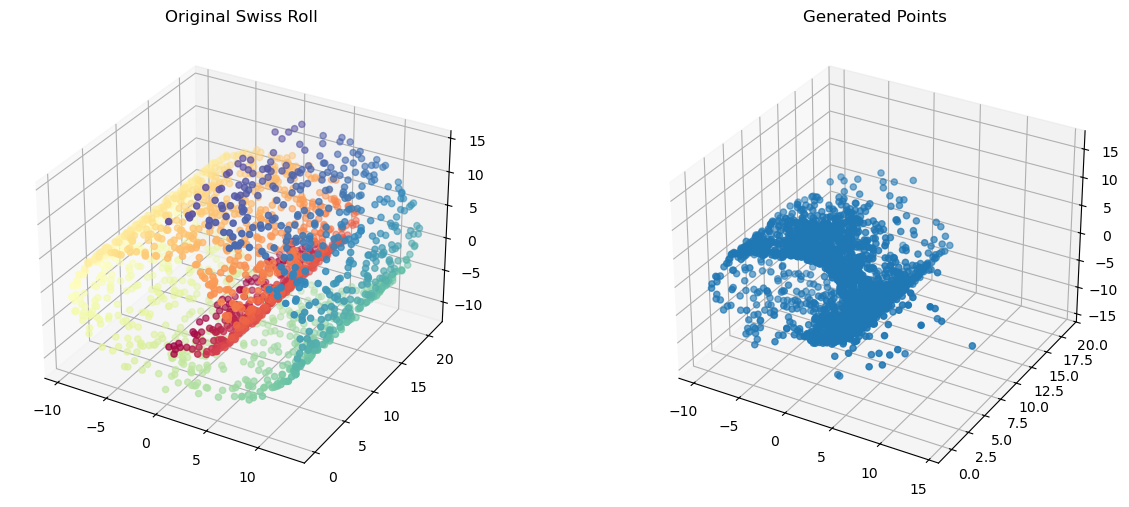

In [24]:
"""Evaluation and Generation"""
# Sample 1000 points from the swiss roll dataset and plot them in a 3 dimensional figure.
# Generate samples
n_samples = 2000
generated_points = langevin_sampling(model=model, num_samples=n_samples, steps=10000, eps=0.001)

# Visualize original and generated points
fig = plt.figure(figsize=(15, 6))

# Original Swiss Roll
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.Spectral)
ax1.set_title("Original Swiss Roll")

# Generated Points
generated_points = generated_points.detach().cpu().numpy()
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(generated_points[:, 0], generated_points[:, 1], generated_points[:, 2], cmap=plt.cm.Spectral)
ax2.set_title("Generated Points")

plt.show()

For this question, I worked with:

- (name, remark)
- (name, remark)

For this question, I referenced a few sites/ papers/ github repositories, especially:

- (remark, link)
- (remark, link)
- (remark, link)
- ...

I spent ... amount of time, I have some suggestions ...

## Question 2: Chow-Liu Algorithm

Reference: 
- https://pgmpy.org/examples/Structure%20Learning%20with%20Chow-Liu.html
- https://github.com/JohnReid/pybool/blob/master/python/pybool/chow_liu_trees.py



**Sample Statistics:**

x1:
Mean: 0.0042
Std: 1.0035

x2:
Mean: -0.0507
Std: 1.7878

x3:
Mean: 3.2082
Std: 4.7439

x4:
Mean: -0.0751
Std: 4.0750

x5:
Mean: 6.4608
Std: 9.4612


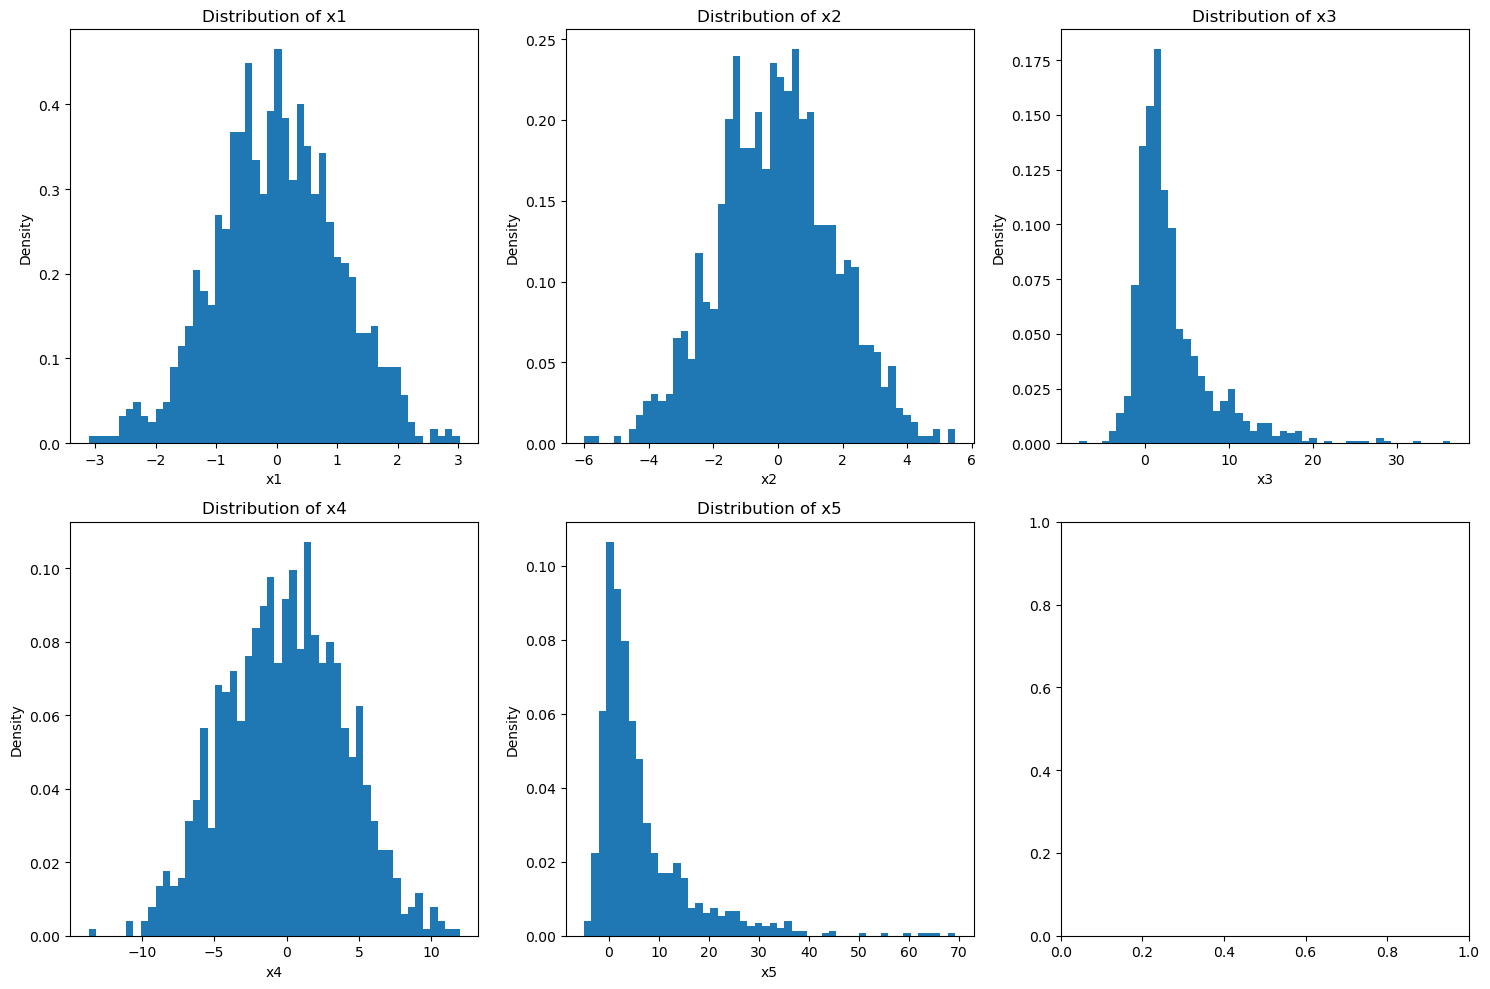

In [1]:
# Bayesian Model
# Write your code here
import torch
import matplotlib.pyplot as plt

class JointDistributionSampler:
    def __init__(self, n_samples=1000, seed=42):
        """
        Initialize the sampler
        
        Args:
            n_samples (int): Number of samples to generate
            seed (int): Random seed for reproducibility
        """
        self.n_samples = n_samples
        torch.manual_seed(seed)
        
    def sample_x1(self):
        """Sample x1 from N(0,1)"""
        return torch.randn(self.n_samples)
    
    def sample_x2(self, x1):
        """
        Sample x2 given x1
        p(x2|x1) = N(x1, 2)
        """
        mean = x1
        std = torch.sqrt(torch.tensor(2.0))
        return mean + std * torch.randn_like(x1)
    
    def sample_x3(self, x1, x2):
        """
        Sample x3 given x1, x2
        p(x3|x1,x2) = N(x1 + x2^2, x1^2 + 1)
        """
        mean = x1 + x2**2
        std = torch.sqrt(x1**2 + 1)
        return mean + std * torch.randn_like(x1)
    
    def sample_x4(self, x2):
        """
        Sample x4 given x2
        p(x4|x2) = N(2x2, 4)
        """
        mean = 2 * x2
        std = torch.sqrt(torch.tensor(4.0))
        return mean + std * torch.randn_like(x2)
    
    def sample_x5(self, x2, x3):
        """
        Sample x5 given x2, x3
        p(x5|x2,x3) = N(x3 + x2^2, x2^2 + 1)
        """
        mean = x3 + x2**2
        std = torch.sqrt(x2**2 + 1)
        return mean + std * torch.randn_like(x2)
    
    def generate_samples(self):
        """
        Generate samples from the joint distribution
        
        Returns:
            tuple: Tensors (x1, x2, x3, x4, x5)
        """
        # Sample x1
        x1 = self.sample_x1()
        
        # Sample x2 given x1
        x2 = self.sample_x2(x1)
        
        # Sample x3 given x1, x2
        x3 = self.sample_x3(x1, x2)
        
        # Sample x4 given x2
        x4 = self.sample_x4(x2)
        
        # Sample x5 given x2, x3
        x5 = self.sample_x5(x2, x3)
        
        return x1, x2, x3, x4, x5

def plot_distributions(samples):
    """
    Plot histograms of the generated samples
    
    Args:
        samples (tuple): Tuple containing (x1, x2, x3, x4, x5)
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, (x, name) in enumerate(zip(samples, ['x1', 'x2', 'x3', 'x4', 'x5'])):
        axes[i].hist(x.numpy(), bins=50, density=True)
        axes[i].set_title(f'Distribution of {name}')
        axes[i].set_xlabel(name)
        axes[i].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()


# Initialize sampler
sampler = JointDistributionSampler(n_samples=1000)

# Generate samples
samples = sampler.generate_samples()

# Print basic statistics
print("\n**Sample Statistics:**")
for i, x in enumerate(samples, 1):
    print(f"\nx{i}:")
    print(f"Mean: {x.mean():.4f}")
    print(f"Std: {x.std():.4f}")

# Plot distributions
plot_distributions(samples)


**Mutual Information Matrix:**
tensor([[0.0000, 0.2557, 0.1865, 0.2120, 0.1383],
        [0.2557, 0.0000, 0.7478, 0.7204, 0.8640],
        [0.1865, 0.7478, 0.0000, 0.2994, 0.9802],
        [0.2120, 0.7204, 0.2994, 0.0000, 0.3141],
        [0.1383, 0.8640, 0.9802, 0.3141, 0.0000]])

**Tree Edges and Mutual Information:**
X1 -> X2: 0.256
X2 -> X5: 0.864
X2 -> X4: 0.720
X5 -> X3: 0.980


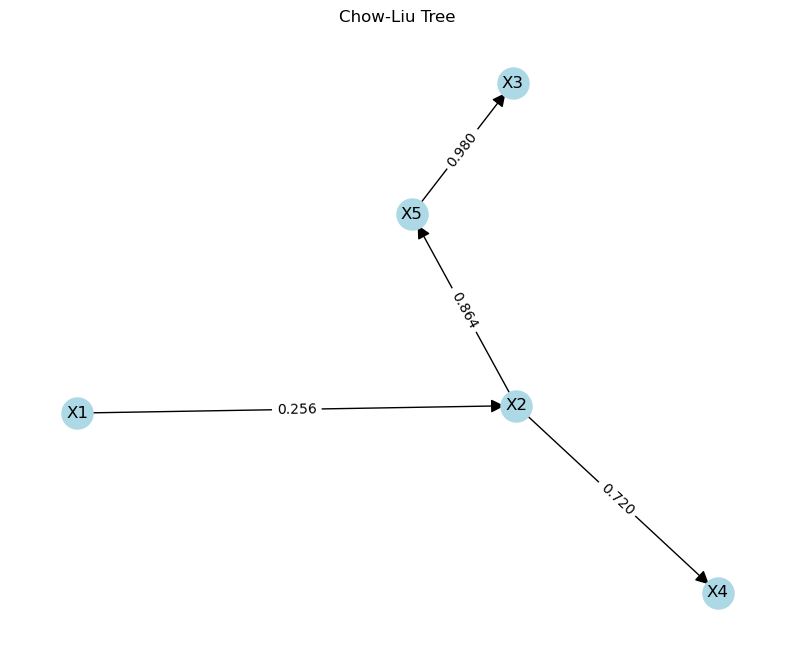

In [4]:
# Chow-Liu algorithm
# Write your code 
import torch
import numpy as np
import networkx as nx
from typing import List, Tuple
import matplotlib.pyplot as plt
from scipy.stats import norm
from torch.distributions.normal import Normal
from mi_estimators import BinningMI, RFFMI

class ChowLiuTree:
    def __init__(self, samples: torch.Tensor, method: str = 'binning', **kwargs):
        """
        Initialize Chow-Liu Tree algorithm
        
        Args:
            samples (torch.Tensor): Data matrix of shape (n_samples, n_variables)
            method (str): Method to use for mutual information estimation
                'binning': Use binning-based MI estimation
                'rff': Use Random Fourier Features-based MI estimation
            **kwargs: Additional arguments for MI estimator
                For binning: bins (int, optional)
                For RFF: n_features (int), gamma (float, optional)
        """
        self.samples = samples
        self.n_variables = samples.shape[1]
        self.n_samples = samples.shape[0]
        self.method = method
        self.mi_kwargs = kwargs
        
    def compute_mutual_information_matrix(self) -> torch.Tensor:
        """
        Compute mutual information matrix using the specified method
        
        Returns:
            torch.Tensor: Matrix of mutual information values
        """
        if self.method == 'binning':
            estimator = BinningMI(self.samples, **self.mi_kwargs)
        elif self.method == 'rff':
            estimator = RFFMI(self.samples, **self.mi_kwargs)
        else:
            raise ValueError(f"Unknown method: {self.method}")
            
        return estimator.compute_pairwise_mi()
        
    
    def get_edge_weights(self) -> List[Tuple[int, int, float]]:
        """
        Convert mutual information matrix to edge list with weights
        
        Returns:
            List[Tuple]: List of (node1, node2, weight) tuples
        """
        mi_matrix = self.compute_mutual_information_matrix()
        edges = []
        
        # Create edge list with weights
        for i in range(self.n_variables):
            for j in range(i + 1, self.n_variables):
                weight = mi_matrix[i, j].item()
                edges.append((i, j, weight))
                
        return edges
    
    def build_tree(self, root_node: int = 0) -> nx.DiGraph:
        """
        Build the Chow-Liu tree using maximum spanning tree
        
        Args:
            root_node (int): Root node for directing the tree
            
        Returns:
            nx.DiGraph: Directed graph representing the Bayesian network
        """
        # Get edge weights (mutual information)
        edges = self.get_edge_weights()
        
        # Create undirected graph
        G = nx.Graph()
        for i, j, weight in edges:
            G.add_edge(i, j, weight=weight)
        
        # Find maximum spanning tree
        mst = nx.maximum_spanning_tree(G)
        
        # Convert to directed graph using BFS
        dag = nx.bfs_tree(mst, root_node)
        
        # Copy weights to directed graph
        for u, v in dag.edges():
            dag[u][v]['weight'] = mst[u][v]['weight']
            
        return dag
    
    def plot_tree(self, dag: nx.DiGraph):
        """
        Plot the directed tree
        
        Args:
            dag (nx.DiGraph): Directed graph to plot
        """
        plt.figure(figsize=(10, 8))
        pos = nx.spring_layout(dag)
        
        # Draw nodes
        nx.draw_networkx_nodes(dag, pos, node_color='lightblue', 
                             node_size=500)
        
        # Draw edges
        nx.draw_networkx_edges(dag, pos, arrows=True, 
                             arrowsize=20)
        
        # Add labels
        labels = {i: f'X{i+1}' for i in range(self.n_variables)}
        nx.draw_networkx_labels(dag, pos, labels)
        
        # Add edge weights (mutual information)
        edge_labels = nx.get_edge_attributes(dag, 'weight')
        edge_labels = {k: f'{v:.3f}' for k, v in edge_labels.items()}
        nx.draw_networkx_edge_labels(dag, pos, edge_labels)
        
        plt.title("Chow-Liu Tree")
        plt.axis('off')
        plt.show()


# Use the previous JointDistributionSampler to generate samples
sampler = JointDistributionSampler(n_samples=10000)
x1, x2, x3, x4, x5 = sampler.generate_samples()

# Stack samples into a matrix
samples = torch.stack([x1, x2, x3, x4, x5], dim=1)

# Create and fit Chow-Liu tree
cl_tree = ChowLiuTree(samples, method='binning')

# Print mutual information matrix
print("\n**Mutual Information Matrix:**")
mi_matrix = cl_tree.compute_mutual_information_matrix()
print(mi_matrix)

# Build the tree with X1 as root
dag = cl_tree.build_tree(root_node=0)

# Print edges and their weights
print("\n**Tree Edges and Mutual Information:**")
for u, v in dag.edges():
    print(f"X{u+1} -> X{v+1}: {dag[u][v]['weight']:.3f}")

# Plot the resulting tree
cl_tree.plot_tree(dag)


/hpc/dctrl/jy384/miniconda3/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


         x1        x2        x3        x4         x5
0  1.926915  0.269007  5.138296 -3.902588   3.377589
1  1.487284  2.062649  6.597061  6.168455  13.140224
2  0.900717  0.028832  0.197937  0.780878   0.853020
3 -2.105521 -2.973386  7.104565 -2.979766  14.239928
4  0.678418  2.215268  5.687057  5.019307  14.211228


Building tree: 100%|██████████| 10/10.0 [00:00<00:00, 423.68it/s]
Building tree: 100%|██████████| 10/10.0 [00:00<00:00, 6221.16it/s]


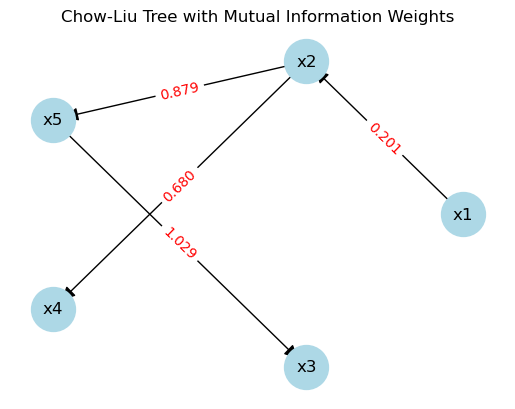

In [3]:
# compare with pgmpy implementation
import pandas as pd
from pgmpy.estimators import TreeSearch
from sklearn.feature_selection import mutual_info_regression
# samples df
samples_df = pd.DataFrame(samples.numpy(), columns=['x1', 'x2', 'x3', 'x4', 'x5'])

print(samples_df.head())

# assert same
assert (samples_df.values == samples.numpy()).all()

def mutual_info_wrapper(x, y):
    # If x is a Series, convert it to a DataFrame
    if isinstance(x, pd.Series):
        x = x.to_frame()
    # mutual_info_regression expects X as 2D and y as 1D
    # Note: mutual_info_regression returns an array, so take the first element for a single feature.
    return mutual_info_regression(x, y)[0]

est = TreeSearch(samples_df, root_node='x1')
weights = est._get_weights(data=samples_df, edge_weights_fn=mutual_info_wrapper)
model = est.estimate(estimator_type='chow-liu', edge_weights_fn=mutual_info_wrapper)

# Let's use a circular layout to help ensure that node positions are well separated.
pos = nx.circular_layout(model)

# Optionally, filter out any edges connecting nodes with nearly identical positions.
filtered_edges = []
for u, v in model.edges():
    if not np.allclose(pos[u], pos[v], atol=1e-3):
        filtered_edges.append((u, v))
if len(filtered_edges) < model.number_of_edges():
    print("Warning: Some edges had degenerate positions and were omitted.")

# Draw nodes and their labels.
nx.draw_networkx_nodes(model, pos, node_color="lightblue", node_size=1000)
nx.draw_networkx_labels(model, pos, font_size=12, font_color="black")

# Draw edges with explicit arrow parameters.
nx.draw_networkx_edges(
    model,
    pos,
    edgelist=filtered_edges,
    arrows=True,
    arrowsize=20,
    arrowstyle="-|>",
    connectionstyle="arc3,rad=0.0"  # Forces straight-line connections
)

# Build edge labels using the mutual information weights.
columns_order = list(samples_df.columns)  # e.g., ['x1', 'x2', ...]
edge_labels = {}
for u, v in model.edges():
    # Only assign labels for filtered edges.
    if (u, v) in filtered_edges:
        i = columns_order.index(u)
        j = columns_order.index(v)
        edge_labels[(u, v)] = f"{weights[i, j]:.3f}"

# Draw edge labels with the same connection style.
nx.draw_networkx_edge_labels(
    model,
    pos,
    edge_labels=edge_labels,
    font_color="red",
    font_size=10,
    connectionstyle="arc3,rad=0.0"
)

plt.title("Chow-Liu Tree with Mutual Information Weights")
plt.axis("off")
plt.show()

For this question, I worked with:

- (name, remark)
- (name, remark)

For this question, I referenced a few sites/ papers/ github repositories, especially:

- (remark, link)
- (remark, link)
- (remark, link)
- ...

I spent ... amount of time, I have some suggestions ...

## Question 3: TARNet

Reference: https://github.com/oddrose/cfrnet

In [221]:
torch.tensor(np.float32(train_ate))

tensor(4.)

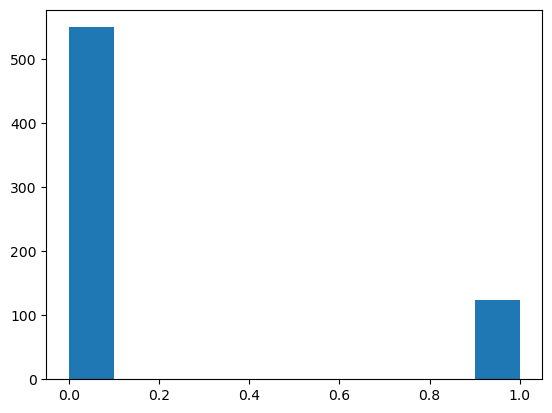

torch.Size([64, 25]) torch.Size([64]) torch.Size([64]) torch.Size([64]) torch.Size([64]) torch.Size([64]) torch.Size([64])
torch.Size([64, 25]) torch.Size([64]) torch.Size([64]) torch.Size([64]) torch.Size([64]) torch.Size([64]) torch.Size([64])
torch.Size([64, 25]) torch.Size([64]) torch.Size([64]) torch.Size([64]) torch.Size([64]) torch.Size([64]) torch.Size([64])
torch.Size([64, 25]) torch.Size([64]) torch.Size([64]) torch.Size([64]) torch.Size([64]) torch.Size([64]) torch.Size([64])
torch.Size([64, 25]) torch.Size([64]) torch.Size([64]) torch.Size([64]) torch.Size([64]) torch.Size([64]) torch.Size([64])
torch.Size([64, 25]) torch.Size([64]) torch.Size([64]) torch.Size([64]) torch.Size([64]) torch.Size([64]) torch.Size([64])
torch.Size([64, 25]) torch.Size([64]) torch.Size([64]) torch.Size([64]) torch.Size([64]) torch.Size([64]) torch.Size([64])
torch.Size([64, 25]) torch.Size([64]) torch.Size([64]) torch.Size([64]) torch.Size([64]) torch.Size([64]) torch.Size([64])
torch.Size([25, 

In [222]:
# load IHDP dataset from /Data/ihdp_npci_1-100.train.npz and /Data/ihdp_npci_1-100.test.npz
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
# import train test split
from sklearn.model_selection import train_test_split
import numpy as np

# def load_ihdp_data(path):
#     data = np.load(path)
#     x = data['x']
#     t = data['t']
#     yf = data['yf']
#     ycf = data['ycf']
#     ate = data['ate']
#     mu0 = data['mu0']
#     mu1 = data['mu1']   
#     return x, t, yf, ycf, ate, mu0, mu1



class IHDPDataset(Dataset):
    def __init__(self, x, t, yf, ycf, ate, mu0, mu1):
        # Convert numpy arrays to torch tensors and ensure correct data types
        self.x = torch.FloatTensor(x)
        self.t = torch.FloatTensor(t)
        self.yf = torch.FloatTensor(yf)
        self.ycf = torch.FloatTensor(ycf)
        self.ate = torch.tensor(ate)
        self.mu0 = torch.FloatTensor(mu0)
        self.mu1 = torch.FloatTensor(mu1)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.t[idx], self.yf[idx], self.ycf[idx], self.ate, self.mu0[idx], self.mu1[idx]

# Load and preprocess the data
train_ihdp_path = './Data/ihdp_npci_1-100.train.npz'
test_ihdp_path = './Data/ihdp_npci_1-100.test.npz'

def load_ihdp_data_one_realization(path):
    data = np.load(path)
    # realization is last dimension
    # select first realization
    x = data['x'][:, :, 0]
    # x_list = []
    # t_list = []
    # yf_list = []
    # for i in range(data['x'].shape[2]):
    #     x_list.append(data['x'][:, :, i])
    #     t_list.append(data['t'][:, i])
    #     yf_list.append(data['yf'][:, i])

    # x = np.concatenate(x_list, axis=0)
    # t = np.concatenate(t_list, axis=0)
    # yf = np.concatenate(yf_list, axis=0)
    
    # print(data['x'].shape)
    # print(data['t'].shape)
    # print(data['yf'].shape)
    # print(data['ycf'].shape)
    # print(data['ate'].shape)
    # print(data['mu0'].shape)
    # print(data['mu1'].shape)

    t = data['t'][:, 0]
    yf = data['yf'][:, 0]
    ycf = data['ycf'][:, 0]
    ate = data['ate']
    mu0 = data['mu0'][:, 0]
    mu1 = data['mu1'][:, 0]
    return x, t, yf, ycf, ate, mu0, mu1

# Load training and test data
train_x, train_t, train_yf, train_ycf, train_ate, train_mu0, train_mu1 = load_ihdp_data_one_realization(train_ihdp_path)
test_x, test_t, test_yf, test_ycf, test_ate, test_mu0, test_mu1 = load_ihdp_data_one_realization(test_ihdp_path)

import matplotlib.pyplot as plt
# check distribution of t
plt.hist(train_t)
plt.show()

# imbalanced in t, need to stratify
train_idx, val_idx = train_test_split(np.arange(len(train_x)), test_size=0.2, stratify=train_t)

# Create datasets
train_dataset = IHDPDataset(train_x[train_idx], train_t[train_idx], train_yf[train_idx], train_ycf[train_idx], train_ate, train_mu0[train_idx], train_mu1[train_idx])
val_dataset = IHDPDataset(train_x[val_idx], train_t[val_idx], train_yf[val_idx], train_ycf[val_idx], train_ate, train_mu0[val_idx], train_mu1[val_idx])

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# print shapes of each thing in train_loader
for x, t, y, ycf, ate, mu0, mu1 in train_loader:
    print(x.shape, t.shape, y.shape, ycf.shape, ate.shape, mu0.shape, mu1.shape)


count 0: 50, count 1: 14
count 0: 53, count 1: 11
count 0: 53, count 1: 11
count 0: 51, count 1: 13
count 0: 51, count 1: 13
count 0: 55, count 1: 9
count 0: 55, count 1: 9
count 0: 52, count 1: 12
count 0: 19, count 1: 6


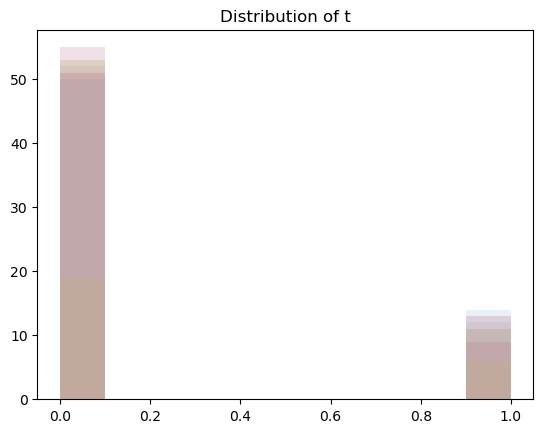

In [223]:
# go through train_loader and plot all distributions of t on the same plot
for i, (x, t, y, _, _, _, _) in enumerate(train_loader):
    plt.hist(t.numpy(), alpha=0.1)
    # also print the count of each t (0, 1)
    print(f"count 0: {t[t == 0].shape[0]}, count 1: {t[t == 1].shape[0]}")

# add legend small
# plt.legend(loc='upper right', fontsize=6)
# add title
plt.title("Distribution of t")
plt.show()

count 0: 56, count 1: 8
count 0: 49, count 1: 15
count 0: 5, count 1: 2


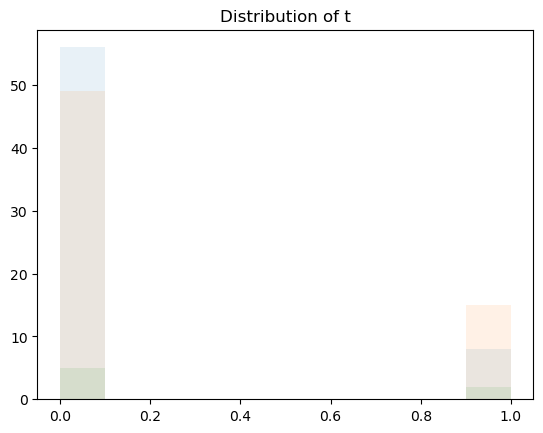

In [191]:
# go through train_loader and plot all distributions of t on the same plot
for i, (x, t, y, _, _, _, _) in enumerate(val_loader):
    plt.hist(t.numpy(), alpha=0.1)
    # also print the count of each t (0, 1)
    print(f"count 0: {t[t == 0].shape[0]}, count 1: {t[t == 1].shape[0]}")

# add legend small
# plt.legend(loc='upper right', fontsize=6)
# add title
plt.title("Distribution of t")
plt.show()

In [224]:
# TARNet Model
# Write your code here

class CommonRepresentation(nn.Module):
    """Shared representation for treatment and control groups with fixed Batch Normalization.
    
    Args:
        input_dim (int): Input dimension.
        hidden_dim (int): Hidden dimension.
        n_layers (int): Number of layers.
    """
    def __init__(self, input_dim, hidden_dim, n_layers=5):
        super(CommonRepresentation, self).__init__()
        layers = []
        for _ in range(n_layers):
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.SiLU())
            input_dim = hidden_dim
        self.layers = nn.Sequential(*layers)

        # BatchNorm1d with no affine parameters ensures fixed scaling.
        self.bn = nn.BatchNorm1d(hidden_dim, affine=False)
  
    def forward(self, x):
        x = self.layers(x)
        x = self.bn(x)
        return x
    
class TreatmentRepresentation(nn.Module):
    """Representation for treatment group. Consists of 5 layers of MLP projections with SiLU activation.
    
    Args:
        input_dim (int): Input dimension, will be the output of the common representation
        hidden_dim (int): Hidden dimension, dimension for the treatment representation
    """
    def __init__(self, input_dim, hidden_dim, n_layers=5):
        super(TreatmentRepresentation, self).__init__()
        treatment_layers = []
        for _ in range(n_layers):
            treatment_layers.append(nn.Linear(input_dim, hidden_dim))
            treatment_layers.append(nn.SiLU())
            input_dim = hidden_dim
        self.treatment_layers = nn.Sequential(*treatment_layers)
        self.output_layer = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        return self.output_layer(self.treatment_layers(x))
    
class ControlRepresentation(nn.Module):
    """Representation for control group. Consists of 5 layers of MLP projections with SiLU activation.
    
    Args:
        input_dim (int): Input dimension, will be the output of the common representation
        hidden_dim (int): Hidden dimension, dimension for the control representation
    """
    def __init__(self, input_dim, hidden_dim, n_layers=5):
        super(ControlRepresentation, self).__init__()
        control_layers = []
        for _ in range(n_layers):
            control_layers.append(nn.Linear(input_dim, hidden_dim))
            control_layers.append(nn.SiLU())
            input_dim = hidden_dim
        self.control_layers = nn.Sequential(*control_layers)
        self.output_layer = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        return self.output_layer(self.control_layers(x))
    
class TARNet(nn.Module):
    def __init__(self, common_input_dim, common_hidden_dim, treatment_hidden_dim, control_hidden_dim):
        super(TARNet, self).__init__()
        self.common_representation = CommonRepresentation(common_input_dim, common_hidden_dim)
        self.treatment_representation = TreatmentRepresentation(common_hidden_dim, treatment_hidden_dim)
        self.control_representation = ControlRepresentation(common_hidden_dim, control_hidden_dim)
        
    def forward(self, x, t):
        # pass x through the transformation $\Phi$
        latent = self.common_representation(x)
        
        # pass latent through the treatment and control heads to get treatment and control representations
        # need to pass to both and not use switch since if else switch is not differentiable
        # concat the treatment and control representations later for end-to-end training
        treatment = self.treatment_representation(latent).squeeze(-1)
        control = self.control_representation(latent).squeeze(-1)
        
        # Create concatenated tensor: [batch_size, 2, rep_dim]
        concat = torch.cat([
            control.unsqueeze(1),  # [batch_size, 1, rep_dim]
            treatment.unsqueeze(1) # [batch_size, 1, rep_dim]
        ], dim=1)  # Final shape: [batch_size, 2, rep_dim]
        
        # Convert treatment indicators to selection indices
        # t needs to be shape [batch_size] with 0/1 values
        batch_indices = torch.arange(len(t), device=t.device)
        # this allows indexing the control and treatment representations separately, 
        # and allow differentiation through the control and treatment heads,
        # since indexing preserves the gradient flow and allows for backpropagation
        selected_output = concat[batch_indices, t.long()]  # t.long() converts t to a tensor of long integers
        
        return selected_output, latent


In [226]:
# Wassertein distance from the Geomloss library using sinkhorn
import torch
from geomloss import SamplesLoss

# Define a Sinkhorn (~Wasserstein-1) loss between sampled measures
wasserstein_distance = SamplesLoss(loss="sinkhorn", p=1, blur=.05)

# check this link for details on w1 implementation: https://www.kernel-operations.io/geomloss/

import torch
import torch.nn as nn
import torch.nn.functional as F
from geomloss import SamplesLoss

# Define the Wasserstein distance using GeomLoss
wasserstein_distance = SamplesLoss(loss="sinkhorn", p=1, blur=.05)

class TarNetCustomLoss(nn.Module):
    def __init__(self, lambda_reg=1.0):
        super(TarNetCustomLoss, self).__init__()
        self.lambda_reg = lambda_reg

    def forward(self, y_pred, y_true, t, common_latent):
        """
        y_pred: predicted factual outcomes (batch_size,)
        y_true: factual outcomes (batch_size,)
        t: treatment indicator (batch_size,) values should be 0 or 1
        common_latent: latent representations from the common representation (batch_size, d)
        """
        # Factual loss (MSE)
        mse_loss = F.mse_loss(y_pred, y_true)
        
        # select indices for control and treatment representations from the latent tensor
        # want \{\Phi(x_i)\}_{i; t_i = 0} and \{\Phi(x_i)\}_{i; t_i = 1}
        treated_idx = (t == 1)
        control_idx = (t == 0)

        # It may be good practice to only compute the regularizer if both groups are present
        if treated_idx.sum() > 0 and control_idx.sum() > 0:
            # Select the representations accordingly
            Phi_treated = common_latent[treated_idx]
            Phi_control = common_latent[control_idx]
            wass_loss = wasserstein_distance(Phi_treated, Phi_control)
        else:
            # make such that can return .item()
            wass_loss = torch.tensor(0.0, device=y_pred.device)
        
        total_loss = mse_loss + self.lambda_reg * wass_loss
        factual_loss = mse_loss
        return total_loss, factual_loss, wass_loss

In [227]:
# train the model
model = TARNet(
    common_input_dim=train_x.shape[1],
    common_hidden_dim=256,
    treatment_hidden_dim=256,
    control_hidden_dim=256
)

# print the model architecture
print(model)

criterion = TarNetCustomLoss(lambda_reg=0.3)


optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)
# cosine annealing
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)
# schedule learning rate with step annealing
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

epochs = 30


# Training loop with validation logging and checkpointing
best_val_loss = float('inf')
train_losses = []
train_factual_losses = []
train_wass_losses = []
val_losses = []
val_factual_losses = []
val_wass_losses = []

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    running_factual_loss = 0.0
    running_wass_loss = 0.0
    
    for batch_idx, (x, t, y, _, _, _, _) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # Forward pass
        y_pred, latent = model(x, t)
        
        # Compute loss
        loss, factual_loss, wass_loss = criterion(y_pred, y, t, latent)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_factual_loss += factual_loss.item()
        running_wass_loss += wass_loss.item()
        
    # update learning rate
    scheduler.step()
    # Calculate average training loss for epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    avg_factual_loss = running_factual_loss / len(train_loader)
    train_factual_losses.append(avg_factual_loss)
    avg_wass_loss = running_wass_loss / len(train_loader)
    train_wass_losses.append(avg_wass_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_factual_loss = 0.0
    val_wass_loss = 0.0
    
    with torch.no_grad():
        for x, t, y, _, _, _, _ in val_loader:
            y_pred, latent = model(x, t)
            loss, factual_loss, wass_loss = criterion(y_pred, y, t, latent)
            val_loss += loss.item()
            val_factual_loss += factual_loss.item()
            val_wass_loss += wass_loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    avg_val_factual_loss = val_factual_loss / len(val_loader)
    val_factual_losses.append(avg_val_factual_loss)
    avg_val_wass_loss = val_wass_loss / len(val_loader)
    val_wass_losses.append(avg_val_wass_loss)
    
    # Print progress
    print(f'Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f} \n Val Loss: {avg_val_loss:.4f} \n \033[92mTrain Factual Loss: {avg_factual_loss:.4f}\033[0m \n \033[92mVal Factual Loss: {avg_val_factual_loss:.4f}\033[0m \n Train Wasserstein Loss: {avg_wass_loss:.4f} \n Val Wasserstein Loss: {avg_val_wass_loss:.4f}')
    
    # Save checkpoint if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'train_factual_loss': avg_factual_loss,
            'val_factual_loss': avg_val_factual_loss,
            'train_wass_loss': avg_wass_loss,
            'val_wass_loss': avg_val_wass_loss
        }
        torch.save(checkpoint, 'best_model_checkpoint.pth')
        
        print(f"\033[91mSaved checkpoint with val loss: {avg_val_loss} < {best_val_loss}", "\033[0m")

TARNet(
  (common_representation): CommonRepresentation(
    (layers): Sequential(
      (0): Linear(in_features=25, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): SiLU()
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): SiLU()
      (6): Linear(in_features=256, out_features=256, bias=True)
      (7): SiLU()
      (8): Linear(in_features=256, out_features=256, bias=True)
      (9): SiLU()
    )
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
  (treatment_representation): TreatmentRepresentation(
    (treatment_layers): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): SiLU()
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): SiLU()
      (6): Linear(in_features=256, out_features=256, bias=True)
     

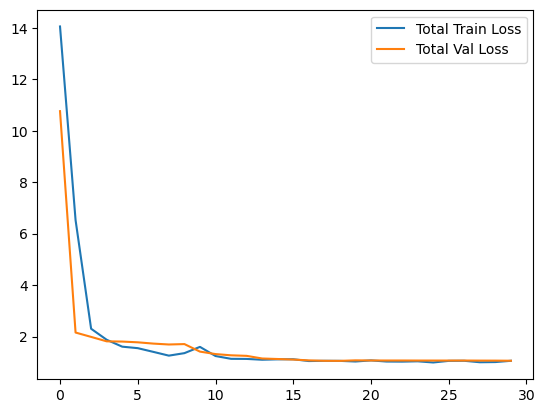

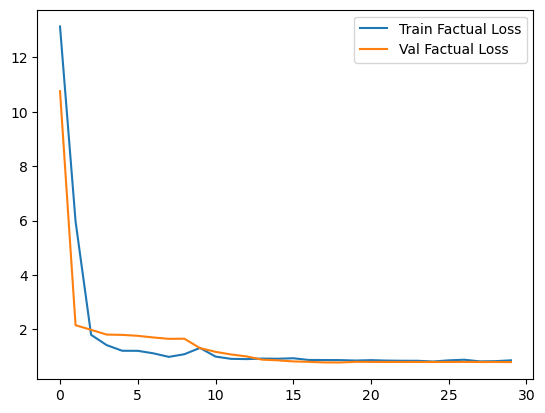

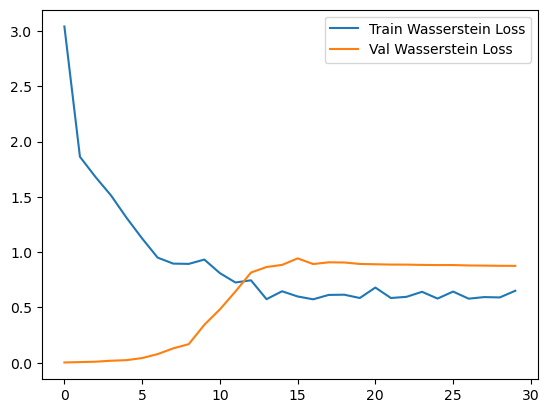

In [236]:
# plot loss curves
plt.plot(train_losses, label='Total Train Loss')
plt.plot(val_losses, label='Total Val Loss')
plt.legend()
plt.show()

plt.plot(train_factual_losses, label='Train Factual Loss')
plt.plot(val_factual_losses, label='Val Factual Loss')
plt.legend()
plt.show()

plt.plot(train_wass_losses, label='Train Wasserstein Loss')
plt.plot(val_wass_losses, label='Val Wasserstein Loss')
plt.legend()
plt.show()


In [233]:
all_y_pred_1 = []
all_y_pred_0 = []
all_mu_diff = []  # if you want to compare with true difference mu1 - mu0
for x, t, y, ycf, ate_value, mu0, mu1 in val_loader:
    # Get predictions for both potential outcomes
    y_pred_1, _ = model(x, torch.ones_like(t))
    y_pred_0, _ = model(x, torch.zeros_like(t))
    
    # Collect predictions
    all_y_pred_1.append(y_pred_1)
    all_y_pred_0.append(y_pred_0)
    
    # True ITE based on mu's if desired:
    true_ite = mu1 - mu0
    all_mu_diff.append(true_ite)

# Concatenate all batches
all_y_pred_1 = torch.cat(all_y_pred_1)
all_y_pred_0 = torch.cat(all_y_pred_0)
pred_ite = all_y_pred_1 - all_y_pred_0  # Compute predicted ITE for each sample
estimated_ATE = pred_ite.mean()  # This is the average treatment effect

# (Optional) Compare with the ground truth ATE:
all_mu_diff = torch.cat(all_mu_diff)
true_ATE = all_mu_diff.mean()

print("Estimated ATE:", estimated_ATE.item())
print("True ATE (using mu1 - mu0):", true_ATE.item())

Estimated ATE: 4.0078125
True ATE (using mu1 - mu0): 3.9558393955230713


For this question, I worked with:

- (name, remark)
- (name, remark)

For this question, I referenced a few sites/ papers/ github repositories, especially:

- (remark, link)
- (remark, link)
- (remark, link)
- ...

I spent ... amount of time, I have some suggestions ...

If you are interested in the above, start thinking about presentation topics and talk to Vahid. <br>
If you are interested in something later on in the class, skim through the slides, also start thinking about presentation topics and talk to Vahid.